\begin{aligned}
-\Delta u & = f && \text {En una resistencia eléctrica},
\\
&\alpha u − \beta = 0 && \text{Con condición en la frontera tipo Robin}\\
& min = z = \frac{P \cdot area}{max_{temp}} && \text{Función Objetivo}
\end{aligned}

- Importar la biblioteca `numpy` con el alias `np`.
- Importar todas las funciones y clases de `ngsolve`.
- Importar la función `Draw` del módulo `webgui` de `ngsolve`.
- Importar la clase `CSG2d`, `Circle` y `Rectangle` del módulo `geom2d` de `netgen`.
- Importar la biblioteca `matplotlib.pyplot` con el alias `plt`.

In [1]:
import numpy as np
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import CSG2d, Circle, Rectangle
import matplotlib.pyplot as plt

- `areamax_tempmax`: Función que calcula el área máxima, la potencia y la temperatura máxima en una geometría.

    - `espesor`: Espesor de la geometría.
    - `radio_externo`: Radio externo de la geometría.
    - `segmentos`: Longitud de los segmentos rectos.
    - `graficar`: Booleano que indica si se debe visualizar la geometría y la solución.

    - Crea la geometría compuesta por dos círculos y dos rectángulos.
    - Genera la malla de la geometría.
    - Calcula el área de la geometría.
    - Calcula la potencia de la geometría.
    - Calcula la máxima temperatura en la geometrVariables de diseño - Parámetros:
        - `espesor`: Espesor de la geometría.
        - `radio_externo`: Radio externo de la geometría.
        - `segmentos`: Longitud de los segmentos rectos.
        - `graficar`: Booleano que indica si se debe visualizar la geometría y la solución.

    - Retorna:
        - `area`: Área de la geometría.
        - `P`: Potencia de la geometría.
        - `max_temp`: Máxima temperatura en la geometría.


In [2]:
def areamax_tempmax(espesor, radio_externo, segmentos, graficar):
    # Crear geometría
    geo = CSG2d()
    circle1 = Circle(center=(segmentos + np.sqrt(radio_externo**2-4), 2), radius=radio_externo, mat="mat1", bc="bc_circle1")
    circle2 = Circle(center=(segmentos + np.sqrt(radio_externo**2-4), 2), radius=radio_externo - espesor, mat="mat2", bc="bc_circle2")
    rect1 = Rectangle(pmin=(0, 0), pmax=(segmentos, 4), mat="mat1", bc="bc_rect1")
    rect2 = Rectangle(pmin=(-0.5, espesor), pmax=(segmentos+2*espesor, 4-espesor), mat="mat2", bc="bc_rect2")
    domain3 = (circle1 + rect1) - (circle2 + rect2)
    geo.Add(domain3)
    # Generar malla
    mesh = geo.GenerateMesh(maxh=espesor/4)
    mesh = Mesh(mesh)
    mesh.Curve(1)
    if graficar: 
        Draw(mesh)

    # Calcular el área
    fes = H1(mesh, order=1, dirichlet="bc_rect1|bc_circle1")
    u = fes.TrialFunction()
    v = fes.TestFunction()
    gfu = GridFunction(fes)
    g = 283.15
    cf = mesh.RegionCF(VOL, dict(mat1=1))
    area = Integrate(cf, mesh, VOL, region_wise=True)
    if graficar:
        print("Área de la geometría:", area, "cm^2")
    temp_max=g

    u = fes.TrialFunction()
    v = fes.TestFunction()
    # Definir coeficiente de conductividad
    cond = 320 * 100  # conductividad térmica 100*kg*cm/(K*s^3)

    # Definir forma bilineal
    a = BilinearForm(fes)
    a += grad(u) * grad(v) * cond * dx
    A_t = espesor * 1
    theta = np.arcsin(1 / 3)
    L_r = segmentos + radio_externo * theta
    P = 1.21e9 * (A_t / L_r)
    if graficar:
        print("Potencia:", P, "e-4 Watts")
    Q = P / area[0]
    f = LinearForm(fes)
    f += Q * v * dx

    gfu.Set(CF(g), BND)
    a.Assemble()
    f.Assemble()

    # Transferencia de calor en la frontera: q = H * (u - T_amb) = H * u - H * T_amb
    H = 250
    T_amb = 283.15
    alpha = H
    beta = -H * T_amb
    robin_boundary = 'bc_rect1|bc_circle1|bc_circle2'
    a += alpha * u * v * ds(robin_boundary)
    f += -beta * v * ds(robin_boundary)
    c = Preconditioner(a, "direct")
    c.Update()
    solvers.BVP(bf=a, lf=f, gf=gfu, pre=c)
    if graficar:
        Draw(gfu)
    max_temp = np.max(gfu.vec.data)
    print(f"g: {temp_max}")
    return area, P, max_temp

- `espesor`, `radio_externo` y `segmentos`: Variables de diseño de la geometría.
- `population_size`: Tamaño de la población.
- `num_iterations`: Número de iteraciones del algoritmo genético.
- `mutation_rate`, `crossover_rate`: Tasas de mutación y cruce respectivamente.
- `elitism`: Booleano que indica si se aplica elitismo en la selección de padres.
- `espesor_range`, `radio_externo_range`, `segmentos_range`: Rangos permitidos para los parámetros de diseño.
- `population`: Población inicial de individuos.
- `objective_function`: Función objetivo que evalúa el rendimiento de un individuo.
- `fitness`: Array que almacena el fitness de cada individuo en la población.
- `best_idx`: Índice del mejor individuo en la población.
- `best_solution`: Mejor solución encontrada.
- `best_fitness`: Mejor rendimiento encontrado.
- `mean_fitnesses`: Lista que almacena el fitness promedio en cada iteración.
- `select_parents`: Función que selecciona dos padres basados en el fitness.
- `crossover`: Función que realiza el cruce de dos padres para producir dos hijos.
- `mutate`: Función que realiza la mutación de un individuo.

In [3]:
espesor = 1.9
radio_externo = 8
segmentos=5
population_size = 20
num_iterations = 10
mutation_rate = 0.01
crossover_rate = 0.4
elitism = False
espesor_range = (0.2, 1.8)
radio_externo_range = (5.0, 12)
segmentos_range = (3, 8)
population = np.random.rand(population_size, 3)
population[:, 0] = population[:, 0] * (espesor_range[1] - espesor_range[0]) + espesor_range[0]
population[:, 1] = population[:, 1] * (radio_externo_range[1] - radio_externo_range[0]) + radio_externo_range[0]
population[:, 2] = population[:, 2] * (segmentos_range[1] - segmentos_range[0]) + segmentos_range[0]

def objective_function(x, graficar):
    area, P, max_temp = areamax_tempmax(espesor=x[0], radio_externo=x[1], segmentos=x[2], graficar=graficar)
    return (P*area)/max_temp

# Calcular el fitness para cada individuo en la población
fitness = np.array([objective_function(x, graficar=True) for x in population])

# Encontrar el mejor individuo en la población
best_idx = np.argmax(fitness)
best_solution = population[best_idx]
best_fitness = fitness[best_idx]

print(f"Mejor solución (espesor, radio_externo, segmentos): {best_solution}")
print(f"Mejor rendimiento: {best_fitness}")

# Calcular y graficar la mejor solución
area, P, max_temp = areamax_tempmax(espesor=best_solution[0], radio_externo=best_solution[1], segmentos=best_solution[2], graficar=False)

print(f"Área: {area}, Potencia: {P}, Temperatura Máxima: {max_temp}")

best_solution = None
best_fitness = float('-inf')
mean_fitnesses = []
def select_parents(population, fitness):
    idxs = np.random.choice(len(population), size=2, replace=False)
    return population[idxs[np.argmax(fitness[idxs])]]
    
def crossover(parent1, parent2):
    if np.random.rand() < crossover_rate:
        child1 = 0.5 * (parent1 + parent2) + np.random.normal(0, 0.1, size=3)
        child2 = 0.5 * (parent1 + parent2) + np.random.normal(0, 0.1, size=3)
        child1[0] = np.clip(child1[0], espesor_range[0], espesor_range[1])
        child1[1] = np.clip(child1[1], radio_externo_range[0], radio_externo_range[1])
        child1[2] = np.clip(child1[2], segmentos_range[0], segmentos_range[1])
        child2[0] = np.clip(child2[0], espesor_range[0], espesor_range[1])
        child2[1] = np.clip(child2[1], radio_externo_range[0], radio_externo_range[1])
        child2[2] = np.clip(child2[2], segmentos_range[0], segmentos_range[1])
        return child1, child2
    return parent1, parent2

def mutate(individual):
    if np.random.rand() < mutation_rate:
        individual += np.random.normal(0, 0.1, size=3)
        individual[0] = np.clip(individual[0], espesor_range[0], espesor_range[1])
        individual[1] = np.clip(individual[1], radio_externo_range[0], radio_externo_range[1])
        individual[2] = np.clip(individual[2], segmentos_range[0], segmentos_range[1])
    return individual

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  42.6201
 cm^2
Potencia: 139423709.52929536 e-4 Watts
CG iteration 1, residual = 763807.4457376744     
CG iteration 2, residual = 5.548732700390709e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  78.6824
 cm^2
Potencia: 301333005.76287025 e-4 Watts
CG iteration 1, residual = 730993.7020759735     
CG iteration 2, residual = 5.140244786274477e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  54.7053
 cm^2
Potencia: 81154191.020471 e-4 Watts
CG iteration 1, residual = 1041634.72244691     
CG iteration 2, residual = 7.519660419639138e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  80.5091
 cm^2
Potencia: 231360850.37911996 e-4 Watts
CG iteration 1, residual = 675155.7489993223     
CG iteration 2, residual = 4.4862565318144814e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  99.8159
 cm^2
Potencia: 329872371.0822877 e-4 Watts
CG iteration 1, residual = 749781.0270114425     
CG iteration 2, residual = 5.595228101978014e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  86.0727
 cm^2
Potencia: 252859863.09710982 e-4 Watts
CG iteration 1, residual = 751818.7262611863     
CG iteration 2, residual = 5.29762362529668e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  19.3891
 cm^2
Potencia: 44233560.566889964 e-4 Watts
CG iteration 1, residual = 1365852.9227676853     
CG iteration 2, residual = 9.230054792085275e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  129.334
 cm^2
Potencia: 221496800.90351918 e-4 Watts
CG iteration 1, residual = 784483.4139301416     
CG iteration 2, residual = 5.26513088456561e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  114.392
 cm^2
Potencia: 176989023.7674082 e-4 Watts
CG iteration 1, residual = 792383.4554653225     
CG iteration 2, residual = 6.203616580485311e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  94.2569
 cm^2
Potencia: 170081121.3722566 e-4 Watts
CG iteration 1, residual = 824279.1526043646     
CG iteration 2, residual = 5.931800584518859e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  18.3969
 cm^2
Potencia: 63174972.31649119 e-4 Watts
CG iteration 1, residual = 1261634.9195734095     
CG iteration 2, residual = 7.925029243510518e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  47.2746
 cm^2
Potencia: 197329242.572085 e-4 Watts
CG iteration 1, residual = 716481.6932562594     
CG iteration 2, residual = 4.997880165124383e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  76.5231
 cm^2
Potencia: 231531002.37995207 e-4 Watts
CG iteration 1, residual = 782957.2899685894     
CG iteration 2, residual = 5.756876644539856e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  91.6806
 cm^2
Potencia: 161283996.50129974 e-4 Watts
CG iteration 1, residual = 893177.2930719095     
CG iteration 2, residual = 6.325559431187488e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  20.5964
 cm^2
Potencia: 52088296.90120913 e-4 Watts
CG iteration 1, residual = 1314038.4272194384     
CG iteration 2, residual = 8.675488700833784e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  63.7987
 cm^2
Potencia: 163190774.60207894 e-4 Watts
CG iteration 1, residual = 832203.9617798569     
CG iteration 2, residual = 5.749546193235583e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  30.5509
 cm^2
Potencia: 63171268.2797231 e-4 Watts
CG iteration 1, residual = 1289884.2095221698     
CG iteration 2, residual = 9.26855183439274e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  36.7113
 cm^2
Potencia: 202699914.2770486 e-4 Watts
CG iteration 1, residual = 713649.9504374611     
CG iteration 2, residual = 5.092250554484828e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:   87.213
 cm^2
Potencia: 230356304.05788168 e-4 Watts
CG iteration 1, residual = 805453.4838365008     
CG iteration 2, residual = 5.951342391385261e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  10.6494
 cm^2
Potencia: 59211298.64182224 e-4 Watts
CG iteration 1, residual = 1227384.4881714922     
CG iteration 2, residual = 8.255234874099763e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15
Mejor solución (espesor, radio_externo, segmentos): [ 1.70486201 11.31363515  5.4685854 ]
Mejor rendimiento: [69951454.15155676]
CG iteration 1, residual = 784483.4139301416     
CG iteration 2, residual = 5.26513088456561e-10     
g: 283.15
Área:  129.334
, Potencia: 221496800.90351918, Temperatura Máxima: 409.52788964931267


- `num_iterations`: Número de iteraciones del algoritmo genético.
- `population_size`: Tamaño de la población.
- `elitism`: Booleano que indica si se aplica elitismo en la selección de padres.
- `select_parents`: Función que selecciona dos padres basados en el fitness.
- `crossover`: Función que realiza el cruce de dos padres para producir dos hijos.
- `mutate`: Función que realiza la mutación de un individuo.
- `population`: Población actual de individuos.
- `fitness`: Array que almacena el fitness de cada individuo en la población.
- `best_solution`: Mejor solución encontrada.
- `best_fitness`: Mejor rendimiento encontrado.
- `mean_fitnesses`: Lista que almacena el fitness promedio en cada iteración.


CG iteration 1, residual = 749781.0270114425     
CG iteration 2, residual = 5.595228101978014e-10     
g: 283.15
CG iteration 1, residual = 751818.7262611863     
CG iteration 2, residual = 5.29762362529668e-10     
g: 283.15
CG iteration 1, residual = 908524.8105531207     
CG iteration 2, residual = 6.493817143634993e-10     
g: 283.15
CG iteration 1, residual = 949838.7695132016     
CG iteration 2, residual = 6.532943776240758e-10     
g: 283.15
CG iteration 1, residual = 800319.8362819611     
CG iteration 2, residual = 6.041364694696096e-10     
g: 283.15
CG iteration 1, residual = 827955.7380849044     
CG iteration 2, residual = 5.833874429618823e-10     
g: 283.15
CG iteration 1, residual = 805453.4838365008     
CG iteration 2, residual = 5.951342391385261e-10     
g: 283.15
CG iteration 1, residual = 792383.4554653225     
CG iteration 2, residual = 6.203616580485311e-10     
g: 283.15
CG iteration 1, residual = 805453.4838365008     
CG iteration 2, residual = 5.9513423913

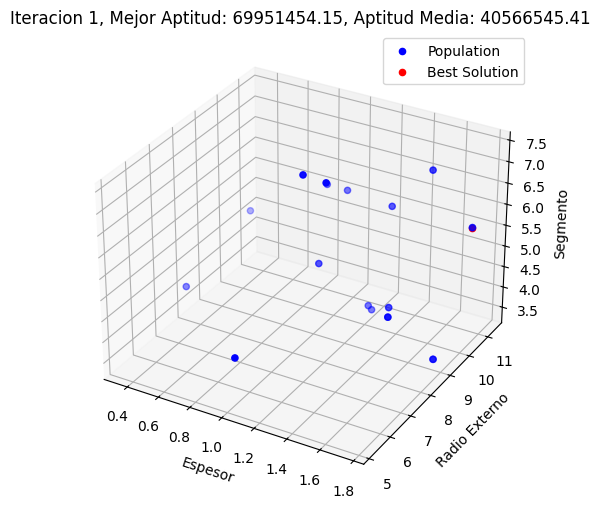

Iteracion 1, Mejor Solucion: [ 1.70486201 11.31363515  5.4685854 ], Mejor Aptitud: 69951454.15155676
CG iteration 1, residual = 786845.1616246499     
CG iteration 2, residual = 5.44918703340886e-10     
g: 283.15
CG iteration 1, residual = 764296.7913760905     
CG iteration 2, residual = 5.755392804987107e-10     
g: 283.15
CG iteration 1, residual = 800319.8362819611     
CG iteration 2, residual = 6.041364694696096e-10     
g: 283.15
CG iteration 1, residual = 832203.9617798569     
CG iteration 2, residual = 5.749546193235583e-10     
g: 283.15
CG iteration 1, residual = 784483.4139301416     
CG iteration 2, residual = 5.26513088456561e-10     
g: 283.15
CG iteration 1, residual = 800319.8362819611     
CG iteration 2, residual = 6.041364694696096e-10     
g: 283.15
CG iteration 1, residual = 750428.0608034617     
CG iteration 2, residual = 5.173217317441845e-10     
g: 283.15
CG iteration 1, residual = 766135.6951259561     
CG iteration 2, residual = 5.604177301557614e-10     

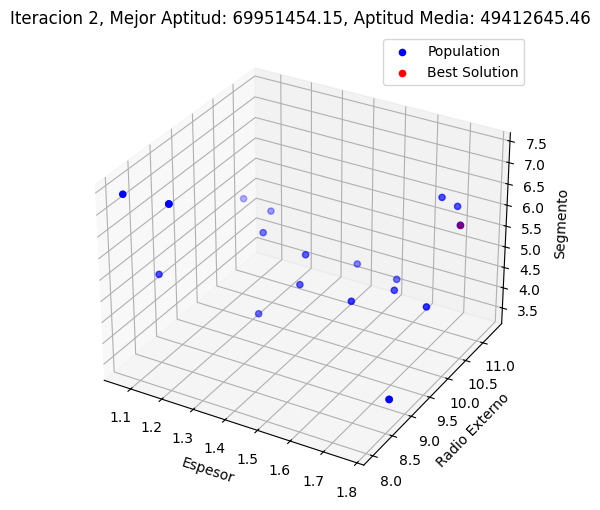

Iteracion 2, Mejor Solucion: [ 1.70486201 11.31363515  5.4685854 ], Mejor Aptitud: 69951454.15155676
CG iteration 1, residual = 749781.0270114425     
CG iteration 2, residual = 5.595228101978014e-10     
g: 283.15
CG iteration 1, residual = 775295.4791789578     
CG iteration 2, residual = 5.992029953223403e-10     
g: 283.15
CG iteration 1, residual = 772967.5278184965     
CG iteration 2, residual = 5.964370252072557e-10     
g: 283.15
CG iteration 1, residual = 797545.1488398041     
CG iteration 2, residual = 5.840465206572638e-10     
g: 283.15
CG iteration 1, residual = 750428.0608034617     
CG iteration 2, residual = 5.173217317441845e-10     
g: 283.15
CG iteration 1, residual = 750428.0608034617     
CG iteration 2, residual = 5.173217317441845e-10     
g: 283.15
CG iteration 1, residual = 772967.5278184965     
CG iteration 2, residual = 5.964370252072557e-10     
g: 283.15
CG iteration 1, residual = 766135.6951259561     
CG iteration 2, residual = 5.604177301557614e-10   

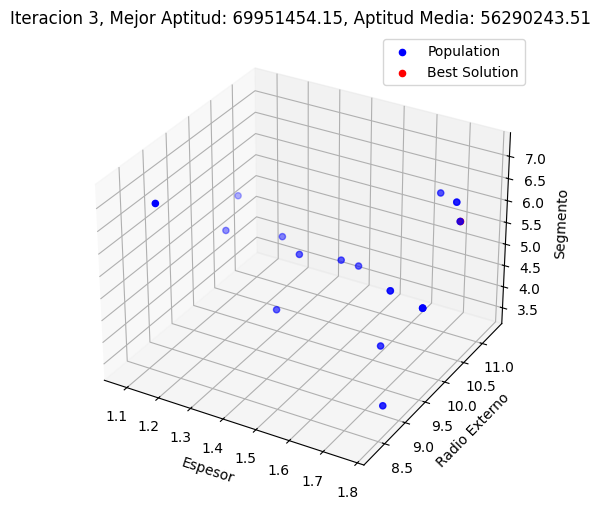

Iteracion 3, Mejor Solucion: [ 1.70486201 11.31363515  5.4685854 ], Mejor Aptitud: 69951454.15155676
CG iteration 1, residual = 750428.0608034617     
CG iteration 2, residual = 5.173217317441845e-10     
g: 283.15
CG iteration 1, residual = 772967.5278184965     
CG iteration 2, residual = 5.964370252072557e-10     
g: 283.15
CG iteration 1, residual = 788550.2299375639     
CG iteration 2, residual = 5.720852713330857e-10     
g: 283.15
CG iteration 1, residual = 766029.1587298977     
CG iteration 2, residual = 5.409078609160025e-10     
g: 283.15
CG iteration 1, residual = 784483.4139301416     
CG iteration 2, residual = 5.26513088456561e-10     
g: 283.15
CG iteration 1, residual = 750428.0608034617     
CG iteration 2, residual = 5.173217317441845e-10     
g: 283.15
CG iteration 1, residual = 765254.4884703254     
CG iteration 2, residual = 5.59741924959419e-10     
g: 283.15
CG iteration 1, residual = 750428.0608034617     
CG iteration 2, residual = 5.173217317441845e-10     

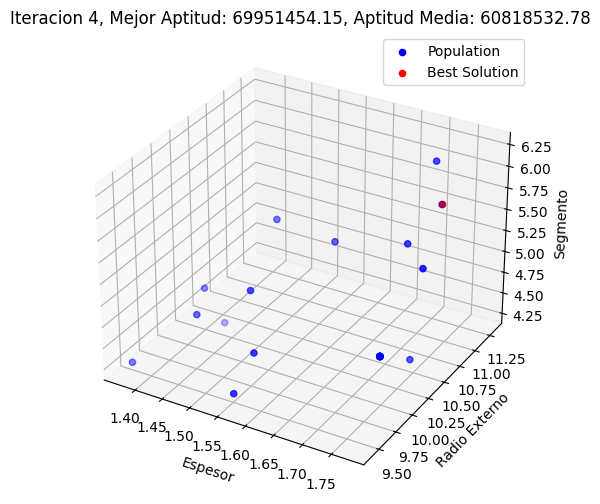

Iteracion 4, Mejor Solucion: [ 1.70486201 11.31363515  5.4685854 ], Mejor Aptitud: 69951454.15155676
CG iteration 1, residual = 757696.216417089     
CG iteration 2, residual = 5.299218654866133e-10     
g: 283.15
CG iteration 1, residual = 762286.3411166213     
CG iteration 2, residual = 5.704722216296212e-10     
g: 283.15
CG iteration 1, residual = 759793.6482523291     
CG iteration 2, residual = 6.118037814638038e-10     
g: 283.15
CG iteration 1, residual = 759445.650677092     
CG iteration 2, residual = 5.883380555743571e-10     
g: 283.15
CG iteration 1, residual = 762364.2574009874     
CG iteration 2, residual = 5.528964334462864e-10     
g: 283.15
CG iteration 1, residual = 772724.1363396625     
CG iteration 2, residual = 6.807975901853971e-10     
g: 283.15
CG iteration 1, residual = 756323.479387563     
CG iteration 2, residual = 5.28011179383843e-10     
g: 283.15
CG iteration 1, residual = 765820.3671106108     
CG iteration 2, residual = 5.660330467097112e-10     
g

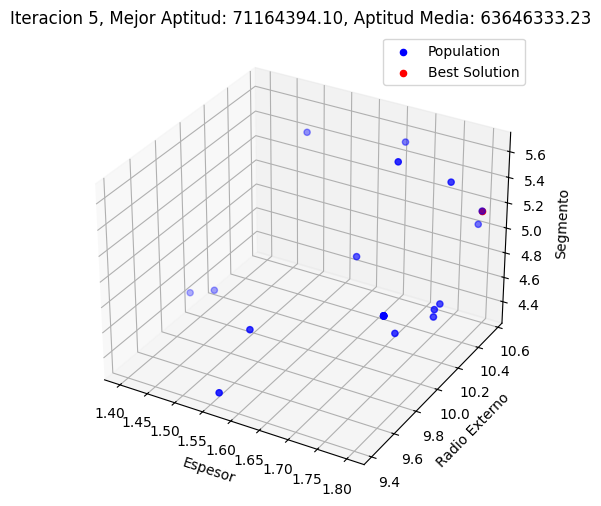

Iteracion 5, Mejor Solucion: [ 1.8        10.55876028  5.16140028], Mejor Aptitud: 71164394.09594078
CG iteration 1, residual = 790278.338057347     
CG iteration 2, residual = 5.815542131313258e-10     
g: 283.15
CG iteration 1, residual = 780041.6178516648     
CG iteration 2, residual = 6.203833430834204e-10     
g: 283.15
CG iteration 1, residual = 762364.2574009874     
CG iteration 2, residual = 5.528964334462864e-10     
g: 283.15
CG iteration 1, residual = 756323.479387563     
CG iteration 2, residual = 5.28011179383843e-10     
g: 283.15
CG iteration 1, residual = 750428.0608034617     
CG iteration 2, residual = 5.173217317441845e-10     
g: 283.15
CG iteration 1, residual = 759793.6482523291     
CG iteration 2, residual = 6.118037814638038e-10     
g: 283.15
CG iteration 1, residual = 756269.4622576827     
CG iteration 2, residual = 5.610153503303509e-10     
g: 283.15
CG iteration 1, residual = 755783.9735006548     
CG iteration 2, residual = 5.264947926173886e-10     


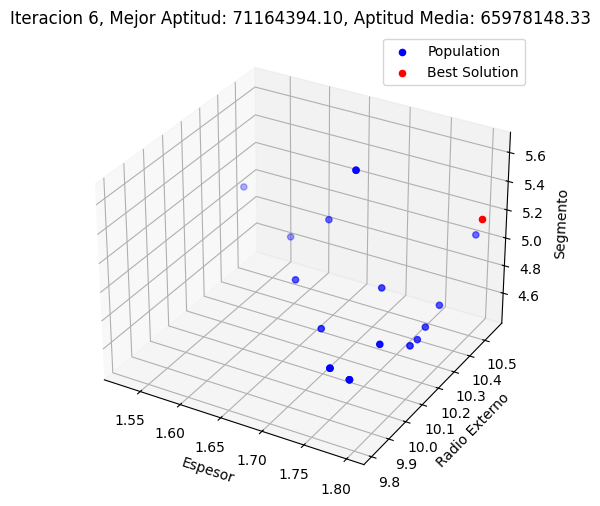

Iteracion 6, Mejor Solucion: [ 1.8        10.55876028  5.16140028], Mejor Aptitud: 71164394.09594078
CG iteration 1, residual = 756323.479387563     
CG iteration 2, residual = 5.28011179383843e-10     
g: 283.15
CG iteration 1, residual = 762286.3411166213     
CG iteration 2, residual = 5.704722216296212e-10     
g: 283.15
CG iteration 1, residual = 755817.9453342827     
CG iteration 2, residual = 5.665348728601651e-10     
g: 283.15
CG iteration 1, residual = 760328.4207247196     
CG iteration 2, residual = 5.476555145889523e-10     
g: 283.15
CG iteration 1, residual = 756259.6620895594     
CG iteration 2, residual = 5.608848365318951e-10     
g: 283.15
CG iteration 1, residual = 756677.8522795341     
CG iteration 2, residual = 5.457837048745291e-10     
g: 283.15
CG iteration 1, residual = 756323.479387563     
CG iteration 2, residual = 5.28011179383843e-10     
g: 283.15
CG iteration 1, residual = 759793.6482523291     
CG iteration 2, residual = 6.118037814638038e-10     
g

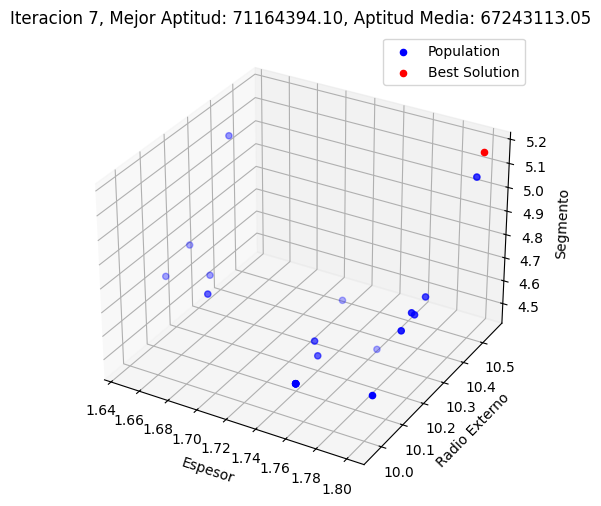

Iteracion 7, Mejor Solucion: [ 1.8        10.55876028  5.16140028], Mejor Aptitud: 71164394.09594078
CG iteration 1, residual = 763005.5009466552     
CG iteration 2, residual = 5.292464957282537e-10     
g: 283.15
CG iteration 1, residual = 760151.6591271589     
CG iteration 2, residual = 5.105823232758482e-10     
g: 283.15
CG iteration 1, residual = 763584.5306386313     
CG iteration 2, residual = 5.456686836736946e-10     
g: 283.15
CG iteration 1, residual = 756259.6620895594     
CG iteration 2, residual = 5.608848365318951e-10     
g: 283.15
CG iteration 1, residual = 756323.479387563     
CG iteration 2, residual = 5.28011179383843e-10     
g: 283.15
CG iteration 1, residual = 756323.479387563     
CG iteration 2, residual = 5.28011179383843e-10     
g: 283.15
CG iteration 1, residual = 763584.5306386313     
CG iteration 2, residual = 5.456686836736946e-10     
g: 283.15
CG iteration 1, residual = 756259.6620895594     
CG iteration 2, residual = 5.608848365318951e-10     
g

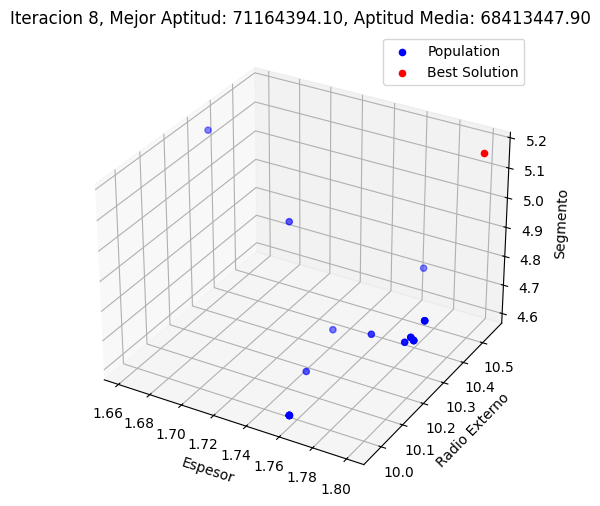

Iteracion 8, Mejor Solucion: [ 1.8        10.55876028  5.16140028], Mejor Aptitud: 71164394.09594078
CG iteration 1, residual = 774347.677207332     
CG iteration 2, residual = 5.535216238640854e-10     
g: 283.15
CG iteration 1, residual = 759156.9774595338     
CG iteration 2, residual = 5.581905829333027e-10     
g: 283.15
CG iteration 1, residual = 763584.5306386313     
CG iteration 2, residual = 5.456686836736946e-10     
g: 283.15
CG iteration 1, residual = 760151.6591271589     
CG iteration 2, residual = 5.105823232758482e-10     
g: 283.15
CG iteration 1, residual = 756259.6620895594     
CG iteration 2, residual = 5.608848365318951e-10     
g: 283.15
CG iteration 1, residual = 763584.5306386313     
CG iteration 2, residual = 5.456686836736946e-10     
g: 283.15
CG iteration 1, residual = 757983.2996044694     
CG iteration 2, residual = 5.821572897892794e-10     
g: 283.15
CG iteration 1, residual = 750955.7941718117     
CG iteration 2, residual = 5.291609221662668e-10    

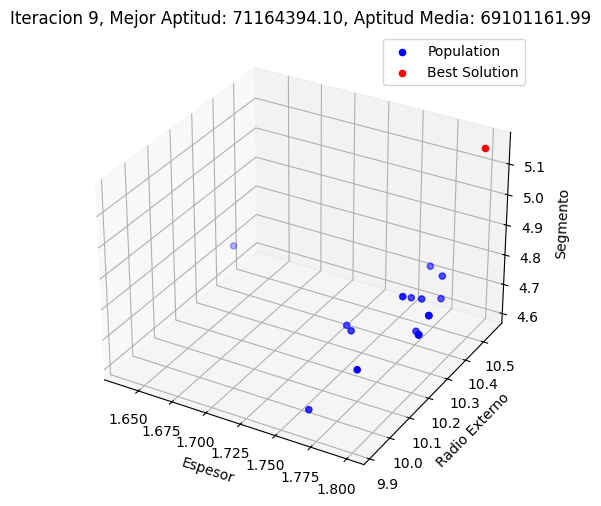

Iteracion 9, Mejor Solucion: [ 1.8        10.55876028  5.16140028], Mejor Aptitud: 71164394.09594078
CG iteration 1, residual = 770842.1998051972     
CG iteration 2, residual = 5.032046313330034e-10     
g: 283.15
CG iteration 1, residual = 768874.7220461305     
CG iteration 2, residual = 5.475142363239641e-10     
g: 283.15
CG iteration 1, residual = 760151.6591271589     
CG iteration 2, residual = 5.105823232758482e-10     
g: 283.15
CG iteration 1, residual = 756677.8522795341     
CG iteration 2, residual = 5.457837048745291e-10     
g: 283.15
CG iteration 1, residual = 756259.6620895594     
CG iteration 2, residual = 5.608848365318951e-10     
g: 283.15
CG iteration 1, residual = 756677.8522795341     
CG iteration 2, residual = 5.457837048745291e-10     
g: 283.15
CG iteration 1, residual = 759247.0389796864     
CG iteration 2, residual = 5.124908054504362e-10     
g: 283.15
CG iteration 1, residual = 760151.6591271589     
CG iteration 2, residual = 5.105823232758482e-10   

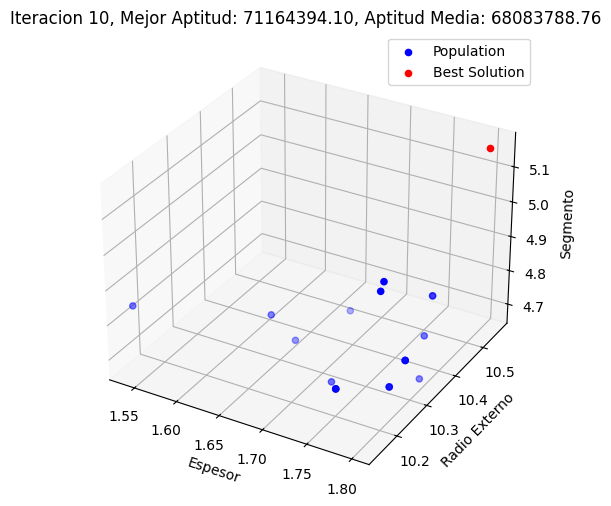

Iteracion 10, Mejor Solucion: [ 1.8        10.55876028  5.16140028], Mejor Aptitud: 71164394.09594078
Mejor Solucion Final (espesor, radio_externo, segmentos): [ 1.8        10.55876028  5.16140028]
Mejor Aptitud Final: 71164394.09594078


In [4]:
# Algoritmo genetico
for j in range(num_iterations):
    # Seleccion de padres y cruce
    new_population = []
    for _ in range(population_size // 2):
        parent1 = select_parents(population, fitness)
        parent2 = select_parents(population, fitness)
        child1, child2 = crossover(parent1, parent2)
        new_population.extend([mutate(child1), mutate(child2)])

    # Elitismo
    if elitism:
        num_elite = int(population_size * 0.10)
        elite_idxs = np.argsort(fitness)[-num_elite:]
        new_population[:num_elite] = population[elite_idxs]

    # Actualizacion de la poblacion
    population = np.array(new_population)

    # Evaluacion de la poblacion
    fitness = np.array([objective_function(x, graficar=False) for x in population])
    mean_fitness = np.mean(fitness)
    mean_fitnesses.append(mean_fitness)

    # Actualizacion de la mejor solucion
    if np.max(fitness) >= best_fitness:
        best_fitness = np.max(fitness)
        best_solution = population[np.argmax(fitness)]

    # Visualizacion
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(population[:, 0], population[:, 1], population[:, 2], c='b', label='Population')
    ax.scatter(best_solution[0], best_solution[1], best_solution[2], c='r', label='Best Solution')
    ax.set_xlabel('Espesor')
    ax.set_ylabel('Radio Externo')
    ax.set_zlabel('Segmento')
    ax.set_title(f"Iteracion {j+1}, Mejor Aptitud: {best_fitness:.2f}, Aptitud Media: {mean_fitness:.2f}")
    ax.legend()
    plt.show()

    print(f"Iteracion {j+1}, Mejor Solucion: {best_solution}, Mejor Aptitud: {best_fitness}")

# Mostrar resultados finales
print(f"Mejor Solucion Final (espesor, radio_externo, segmentos): {best_solution}")
print(f"Mejor Aptitud Final: {best_fitness}")

- `print(f"Iteracion {j+1}, Mejor Solucion: {best_solution}, Mejor Aptitud: {best_fitness}")`: Imprime la iteración actual, la mejor solución encontrada hasta el momento y su aptitud.

- `print(f"Mejor Solucion Final (espesor, radio_externo, segmentos): {best_solution}")`: Imprime la mejor solución final encontrada, especificando sus valores para espesor, radio externo y segmentos.

- `print(f"Mejor Aptitud Final: {best_fitness}")`: Imprime la mejor aptitud final encontrada.

- `area, P, max_temp = areamax_tempmax(espesor=best_solution[0], radio_externo=best_solution[1], segmentos=best_solution[2], graficar=True)`: Calcula y muestra la mejor solución con su geometría y resultados. Esta función parece calcular el área, potencia y temperatura máxima para una geometría específica dada por los parámetros de la mejor solución encontrada, y también grafica la geometría.

- `print(f"Mejor Solucion (espesor, radio_externo, segmentos): {best_solution}")`: Imprime la mejor solución encontrada, especificando sus valores para espesor, radio externo y segmentos.

- `print(f"Area: {area}, Potencia: {P}, Temperatura Maxima: {max_temp}")`: Imprime el área, potencia y temperatura máxima calculados para la mejor solución.solución.


In [5]:
print(f"Iteracion {j+1}, Mejor Solucion: {best_solution}, Mejor Aptitud: {best_fitness}")

# Mostrar resultados finales
print(f"Mejor Solucion Final (espesor, radio_externo, segmentos): {best_solution}")
print(f"Mejor Aptitud Final: {best_fitness}")

# Calcular y mostrar la mejor solucion con su geometria y resultados
area, P, max_temp = areamax_tempmax(espesor=best_solution[0], radio_externo=best_solution[1], segmentos=best_solution[2], graficar=True)
print(f"Mejor Solucion (espesor, radio_externo, segmentos): {best_solution}")
print(f"Area: {area}, Potencia: {P}, Temperatura Maxima: {max_temp}")

Iteracion 10, Mejor Solucion: [ 1.8        10.55876028  5.16140028], Mejor Aptitud: 71164394.09594078
Mejor Solucion Final (espesor, radio_externo, segmentos): [ 1.8        10.55876028  5.16140028]
Mejor Aptitud Final: 71164394.09594078


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  126.668
 cm^2
Potencia: 248924050.85567978 e-4 Watts
CG iteration 1, residual = 759445.650677092     
CG iteration 2, residual = 5.883380555743571e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

g: 283.15
Mejor Solucion (espesor, radio_externo, segmentos): [ 1.8        10.55876028  5.16140028]
Area:  126.668
, Potencia: 248924050.85567978, Temperatura Maxima: 443.07034766394605



- `best_solutions = []` y `mean_fitnesses = []`: Inicializan para guardar la mejor solución y el fitness medio por iteración.

- Algoritmo genético:
  - `for j in range(num_iterations):`: Itera sobre el número de iteraciones especificado.
    - Selección de padres y cruce:
      - `new_population = []` inicializa una nueva población.
      - Para cada pareja de padres:
        - `parent1` y `parent2` son seleccionados usando la función `select_parents`.
        - `child1` y `child2` son creados mediante la función `crossover`.
        - Los hijos mutados son añadidos a `new_population`.
    - Elitismo:
      - Si se activa el elitismo (`elitism`), se guarda una fracción de la población más apta.
    - Actualización de la población y evaluación:
      - La población se actualiza con la nueva generación.
      - Se evalúa la aptitud de cada individuo en la población.
      - Se calcula la aptitud media y se guarda en `mean_fitnesses`.
    - Actualización de la mejor solución:
      - Si se encuentra una mejor aptitud, se actualiza la mejor solución.
    - Se guarda la mejor solución en `best_solutions`.

- Visualización de la mejora de las soluciones:
  - Se crean subgráficos para mostrar la mejora de cada variable por iteración.
  - Se muestra la distribución de soluciones de la primera y última generación en gráficos 3D.

- Graficar el valor del fitness vs iteración:
  - Se muestra cómo varía el fitness medio a lo largo de las iteraciones.

CG iteration 1, residual = 778686.7272604461     
CG iteration 2, residual = 5.830645553757327e-10     
g: 283.15
CG iteration 1, residual = 754705.1197783591     
CG iteration 2, residual = 5.360309203842212e-10     
g: 283.15
CG iteration 1, residual = 755666.2553122983     
CG iteration 2, residual = 5.460318601672846e-10     
g: 283.15
CG iteration 1, residual = 755998.9953481057     
CG iteration 2, residual = 5.410614278894903e-10     
g: 283.15
CG iteration 1, residual = 757900.1315162776     
CG iteration 2, residual = 5.422296211587544e-10     
g: 283.15
CG iteration 1, residual = 765138.1645725053     
CG iteration 2, residual = 5.164848155939669e-10     
g: 283.15
CG iteration 1, residual = 756677.8522795341     
CG iteration 2, residual = 5.457837048745291e-10     
g: 283.15
CG iteration 1, residual = 756259.6620895594     
CG iteration 2, residual = 5.608848365318951e-10     
g: 283.15
CG iteration 1, residual = 759156.9774595338     
CG iteration 2, residual = 5.581905829

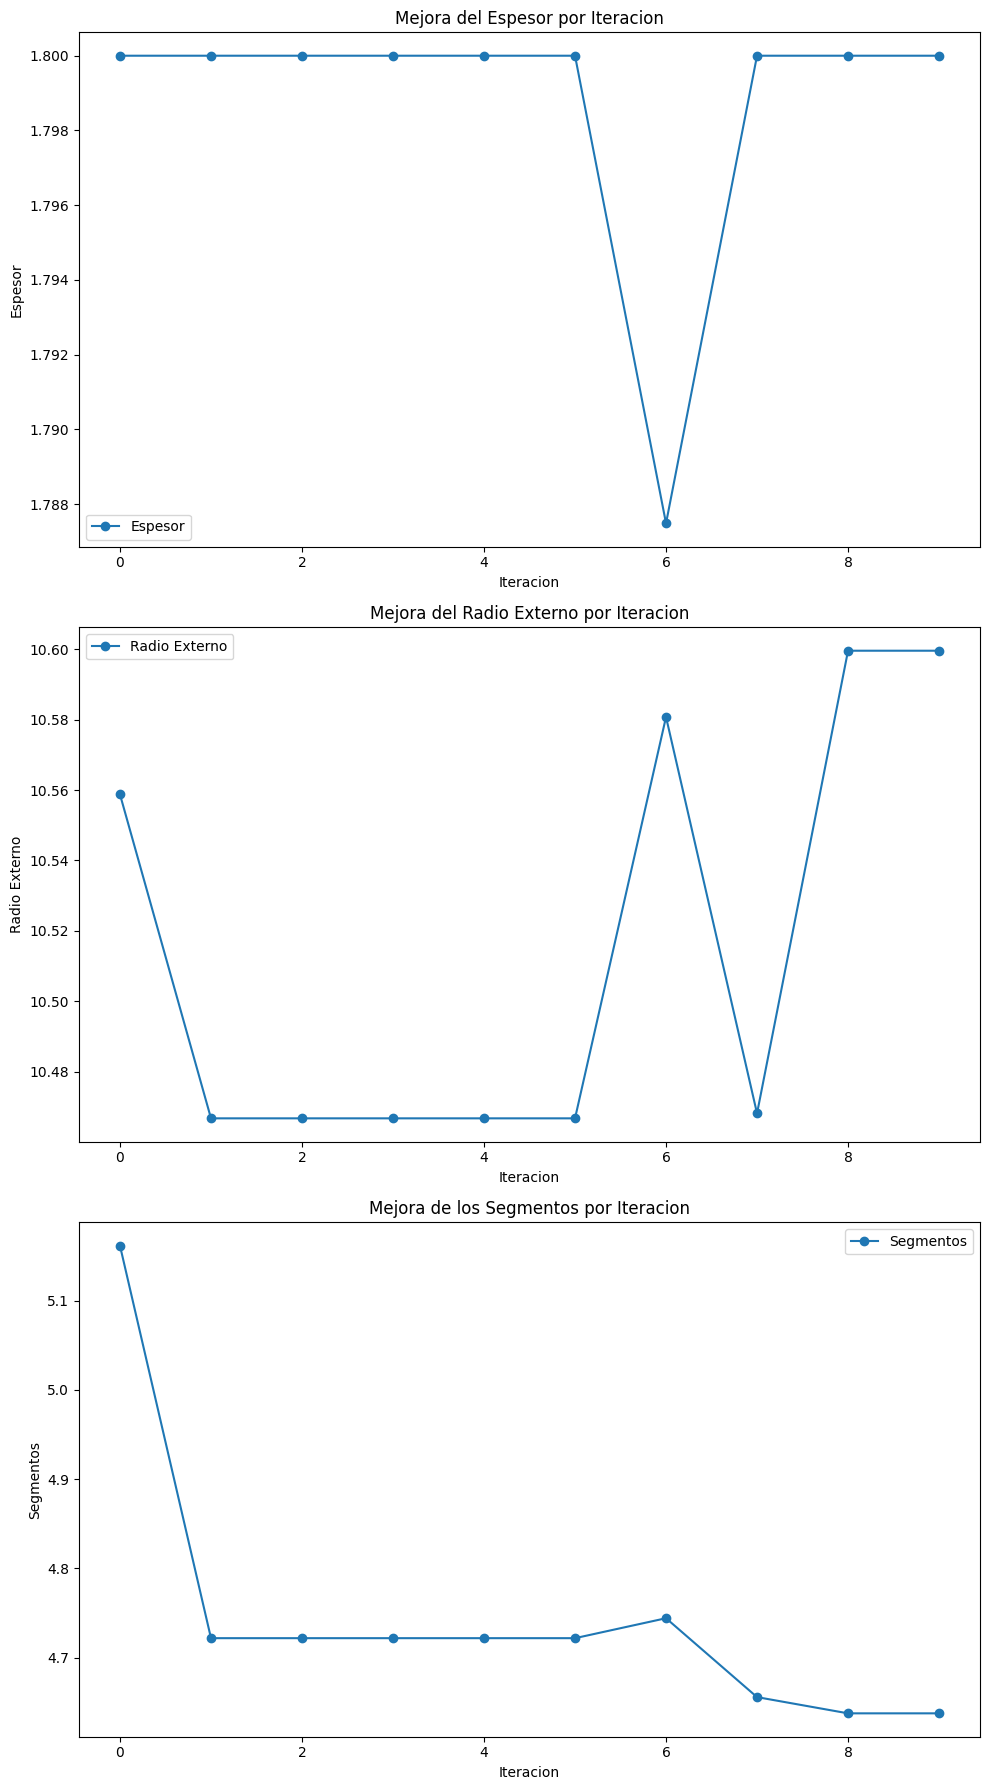

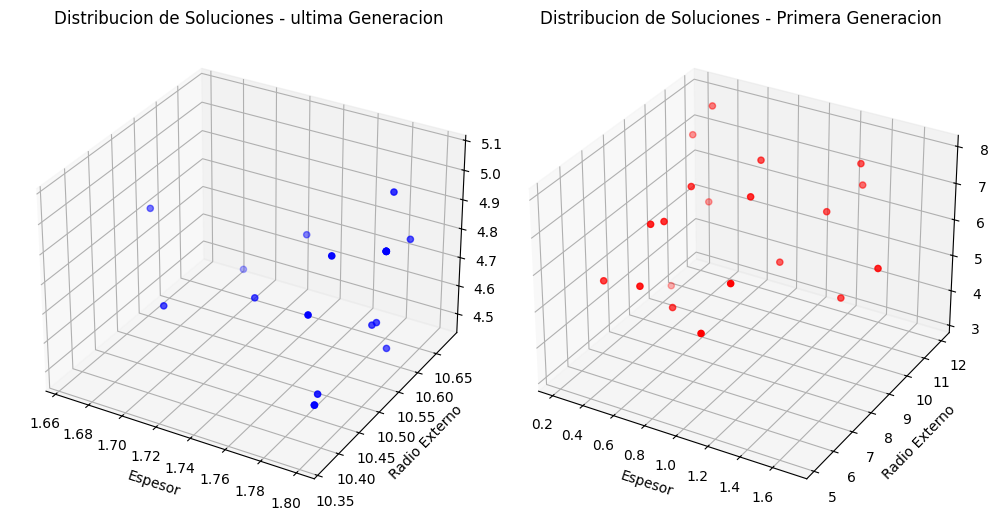

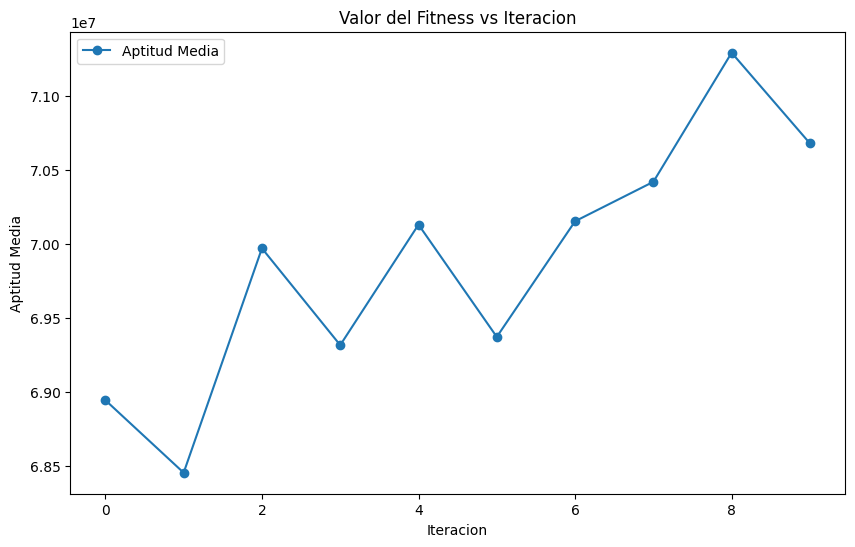

In [6]:
# Inicializa para guardar la mejor solucion y el fitness medio por iteracion
best_solutions = []
mean_fitnesses = []

# Algoritmo genetico
for j in range(num_iterations):
    # Seleccion de padres y cruce
    new_population = []
    for _ in range(population_size // 2):
        parent1 = select_parents(population, fitness)
        parent2 = select_parents(population, fitness)
        child1, child2 = crossover(parent1, parent2)
        new_population.extend([mutate(child1), mutate(child2)])

    # Elitismo
    if elitism:
        num_elite = int(population_size * 0.10)
        elite_idxs = np.argsort(fitness)[-num_elite:]
        new_population[:num_elite] = population[elite_idxs]

    # Actualizacion de la poblacion
    population = np.array(new_population)

    # Evaluacion de la poblacion
    fitness = np.array([objective_function(x, graficar=False) for x in population])
    mean_fitness = np.mean(fitness)
    mean_fitnesses.append(mean_fitness)

    # Actualizacion de la mejor solucion
    if np.max(fitness) >= best_fitness:
        best_fitness = np.max(fitness)
        best_solution = population[np.argmax(fitness)]

    # Guardar las mejores soluciones
    best_solutions.append(best_solution)

    # Visualizacion de la mejora de las soluciones
    #print(f"Iteracion {j+1}, Mejor Solucion: {best_solution}, Mejor Aptitud: {best_fitness}")

# Graficar la mejora de las soluciones (resaltar las variables y funcion fitness)
best_solutions = np.array(best_solutions)
fig, ax = plt.subplots(3, 1, figsize=(10, 18))

ax[0].plot(range(num_iterations), best_solutions[:, 0], 'o-', label='Espesor')
ax[0].set_xlabel('Iteracion')
ax[0].set_ylabel('Espesor')
ax[0].set_title('Mejora del Espesor por Iteracion')
ax[0].legend()

ax[1].plot(range(num_iterations), best_solutions[:, 1], 'o-', label='Radio Externo')
ax[1].set_xlabel('Iteracion')
ax[1].set_ylabel('Radio Externo')
ax[1].set_title('Mejora del Radio Externo por Iteracion')
ax[1].legend()

ax[2].plot(range(num_iterations), best_solutions[:, 2], 'o-', label='Segmentos')
ax[2].set_xlabel('Iteracion')
ax[2].set_ylabel('Segmentos')
ax[2].set_title('Mejora de los Segmentos por Iteracion')
ax[2].legend()

plt.tight_layout()
plt.show()

# Distribucion de soluciones en la primera y ultima generacion
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(population[:, 0], population[:, 1], population[:, 2], c='b', label='ultima Generacion')
ax1.set_xlabel('Espesor')
ax1.set_ylabel('Radio Externo')
ax1.set_zlabel('Segmentos')
ax1.set_title('Distribucion de Soluciones - ultima Generacion')

ax2 = fig.add_subplot(122, projection='3d')
initial_population = np.random.rand(population_size, 3)
initial_population[:, 0] = initial_population[:, 0] * (espesor_range[1] - espesor_range[0]) + espesor_range[0]
initial_population[:, 1] = initial_population[:, 1] * (radio_externo_range[1] - radio_externo_range[0]) + radio_externo_range[0]
initial_population[:, 2] = initial_population[:, 2] * (segmentos_range[1] - segmentos_range[0]) + segmentos_range[0]
ax2.scatter(initial_population[:, 0], initial_population[:, 1], initial_population[:, 2], c='r', label='Primera Generacion')
ax2.set_xlabel('Espesor')
ax2.set_ylabel('Radio Externo')
ax2.set_zlabel('Segmentos')
ax2.set_title('Distribucion de Soluciones - Primera Generacion')

plt.tight_layout()
plt.show()

# Graficar el valor del fitness vs iteracion
plt.figure(figsize=(10, 6))
plt.plot(range(num_iterations), mean_fitnesses, 'o-', label='Aptitud Media')
plt.xlabel('Iteracion')
plt.ylabel('Aptitud Media')
plt.title('Valor del Fitness vs Iteracion')
plt.legend()
plt.show()

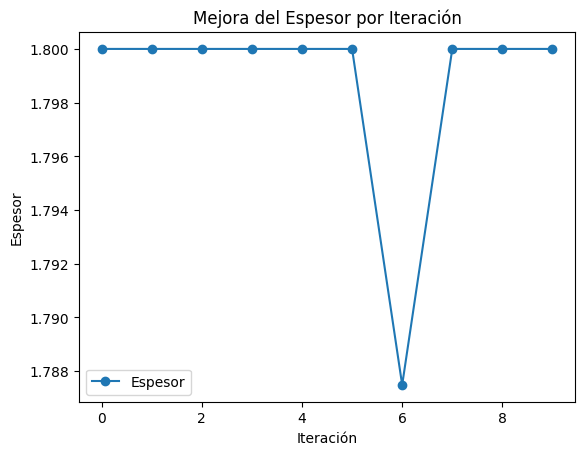

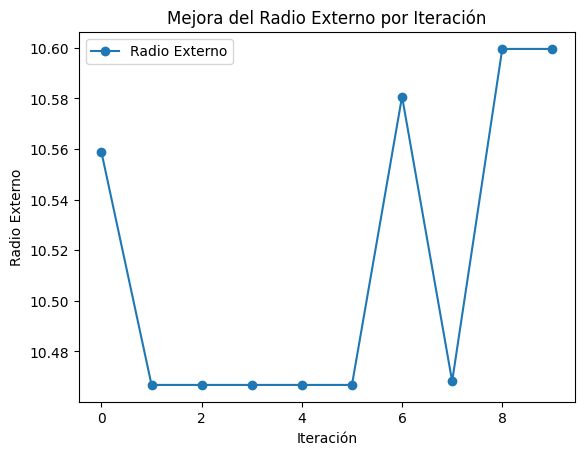

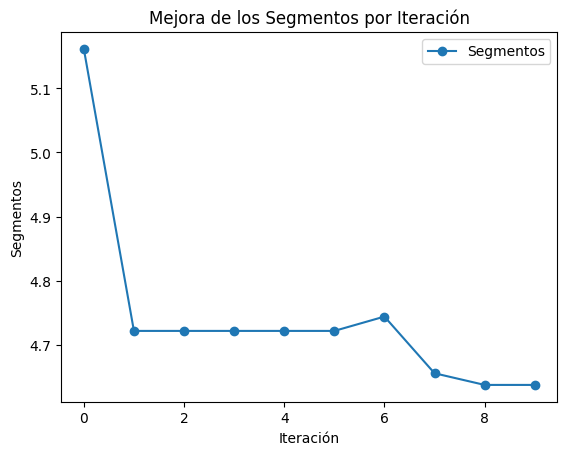

In [7]:
# Gráfico 1: Mejora del Espesor por Iteración
fig1, ax1 = plt.subplots()
ax1.plot(range(num_iterations), best_solutions[:, 0], 'o-', label='Espesor')
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Espesor')
ax1.set_title('Mejora del Espesor por Iteración')
ax1.legend()
plt.show()

# Gráfico 2: Mejora del Radio Externo por Iteración
fig2, ax2 = plt.subplots()
ax2.plot(range(num_iterations), best_solutions[:, 1], 'o-', label='Radio Externo')
ax2.set_xlabel('Iteración')
ax2.set_ylabel('Radio Externo')
ax2.set_title('Mejora del Radio Externo por Iteración')
ax2.legend()
plt.show()

# Gráfico 3: Mejora de los Segmentos por Iteración
fig3, ax3 = plt.subplots()
ax3.plot(range(num_iterations), best_solutions[:, 2], 'o-', label='Segmentos')
ax3.set_xlabel('Iteración')
ax3.set_ylabel('Segmentos')
ax3.set_title('Mejora de los Segmentos por Iteración')
ax3.legend()
plt.show()